In [1]:
elastic_rods_dir = '../../../../elastic_rods/python/'
weaving_dir = '../../../'
import os
import os.path as osp
import sys; sys.path.append(elastic_rods_dir); sys.path.append(weaving_dir)
import numpy as np, elastic_rods, linkage_vis
import numpy.linalg as la
from bending_validation import suppress_stdout as so
import matplotlib.pyplot as plt
from elastic_rods import EnergyType, InterleavingType

# weaving
import analysis_helper, ribbon_linkage_helper, mesh_vis, linkage_utils, compute_curve_from_curvature, pipeline_helper, importlib
importlib.reload(analysis_helper)
importlib.reload(ribbon_linkage_helper)
importlib.reload(mesh_vis)
importlib.reload(linkage_utils)
importlib.reload(compute_curve_from_curvature)
importlib.reload(pipeline_helper)
from analysis_helper import (compare_turning_angle,
                            is_on_sphere, 
                            get_distance_to_center_scalar_field, 
                            plot_curvatures, 
                            get_curvature_scalar_field,
                            construct_elastic_rod_loop_from_rod_segments, 
                            concatenate_rod_properties_from_rod_segments, 
                            compute_min_distance_rigid_transformation)
from ribbon_linkage_helper import (update_rest_curvature, 
                                   set_ribbon_linkage,
                                   export_linkage_geometry_to_obj,
                                   write_linkage_ribbon_output_florin,
                                   write_distance_to_linkage_mesh)

from compute_curve_from_curvature import (match_geo_curvature_and_edge_len, get_all_curve_pattern)
from linkage_utils import order_segments_by_ribbons, get_turning_angle_and_length_from_ordered_rods

from pipeline_helper import (initialize_linkage, get_normal_deviation, set_joint_vector_field, stage_1_optimization, initialize_stage_2_optimizer, stage_2_optimization, InputOrganizer, write_all_output, set_surface_view_options, get_structure_analysis_view, contact_optimization, get_double_side_view, show_selected_joints, highlight_rod_and_joint, set_design_parameters_from_topology)
import vis.fields
import matplotlib.cm as cm
import time

In [3]:
import parallelism
parallelism.set_max_num_tbb_threads(24)
parallelism.set_hessian_assembly_num_threads(8)
parallelism.set_gradient_assembly_num_threads(8)

In [4]:
rod_length = 0.09982061776030171
width = rod_length / 15 * 5
thickness = width / 5 * 0.35
print(width, thickness)
io = InputOrganizer('new_kitty_1', thickness, width, weaving_dir)
#  [ ear 214, ear 255, nose 39]

0.033273539253433904 0.0023291477477403733


In [5]:
import py_newton_optimizer
OPTS = py_newton_optimizer.NewtonOptimizerOptions()
OPTS.gradTol = 1e-6
OPTS.verbose = 1;
OPTS.beta = 1e-8
OPTS.niter = 200
OPTS.verboseNonPosDef = False
rw = 1
sw = 10
drw = 0.01
dsw = 0.01

In [6]:
# import pickle 
# import gzip
# pickle.dump(curved_linkage, gzip.open('{}_no_feature_joints_20201209.pkl.gz'.format(io.MODEL_NAME), 'w'))

In [7]:
with so(): curved_linkage = initialize_linkage(surface_path = io.SURFACE_PATH, useCenterline = True, model_path = io.MODEL_PATH, cross_section = io.RIBBON_CS, subdivision_res = io.SUBDIVISION_RESOLUTION)
curved_linkage.set_design_parameter_config(use_restLen = True, use_restKappa = True)
curved_save_tgt_joint_pos = curved_linkage.jointPositions();
curved_linkage_view = linkage_vis.LinkageViewerWithSurface(curved_linkage, io.SURFACE_PATH)
set_surface_view_options(curved_linkage_view)
curved_linkage_view.show()

Renderer(camera=PerspectiveCamera(children=(PointLight(color='#999999', position=(0.0, 0.0, 5.0), quaternion=(…

In [9]:
set_surface_view_options(curved_linkage_view, surface_transparent = True)

In [10]:
double_view = get_double_side_view(curved_linkage, flip = True)

In [11]:
# double_view.show()

In [12]:
double_view.getCameraParams()

((0.0, 0.0, 5.0), (0.0, 1.0, 0.0), (0.0, 0.0, 0.0))

In [8]:
curved_linkage.attraction_weight = 0.5

In [28]:
def normalize(vec):
    return vec / la.norm(vec)

In [29]:
pts = curved_linkage.get_closest_point_for_visualization(np.array(curved_linkage.deformedPoints()).flatten())
pts = np.reshape(pts, (int(len(pts)/3), 3))

In [21]:
curved_linkage.numSegments()

1032

In [20]:
21672 / 21

1032.0

In [28]:
def set_design_parameters_from_topology(curved_linkage, io):
    def normalize(vec):
        return vec / la.norm(vec)
    all_pts = curved_linkage.get_closest_point_for_visualization(np.array(curved_linkage.deformedPoints()).flatten())
    all_normals = np.array(curved_linkage.get_closest_point_normal(all_pts))
    all_pts = np.reshape(all_pts, (curved_linkage.numSegments(), io.SUBDIVISION_RESOLUTION + 1, 3))
    all_normals = np.reshape(all_normals, (curved_linkage.numSegments(), io.SUBDIVISION_RESOLUTION + 1, 3))
    def set_segment_rest_kappa(curved_linkage, i):
        print('curvature ', i,  flush=True)
        rod = curved_linkage.segment(i).rod
        pts = all_pts[i]
        normals = all_normals[i]
        # Flip normal by directors.
        dc = rod.deformedConfiguration()
        directors = []
        directors.append(dc.materialFrame[0].d2)
        directors.extend([normalize(dc.materialFrame[edge_index - 1].d2 + dc.materialFrame[edge_index].d2) for edge_index in range(io.SUBDIVISION_RESOLUTION)[1:]])
        directors.append(dc.materialFrame[-1].d2)
        normals = np.array([normals[i] if np.dot(normals[i], directors[i]) > 0 else normals[i] * -1 for i in range(len(normals))])
        edges = np.array([pts[i+1] - pts[i] for i in range(len(pts)-1)])

        def get_rest_kappa(e1, e2, pn):
            cb = 2 * np.cross(e1, e2) / (la.norm(e1) * la.norm(e2) + np.dot(e1, e2))
            return np.dot(cb, pn)

        kappas = np.array([get_rest_kappa(edges[i], edges[i+1], normals[i+1]) for i in range(len(edges) - 1)])
        current_rk = rod.restKappas()

        for j in range(len(current_rk) - 2):
            current_rk[j+1][0] = kappas[j]
        curved_linkage.segment(i).rod.setRestKappas(current_rk)


    # Set rest length.
    segment_rest_length = []
    for i in range(curved_linkage.numSegments()):
        rod = curved_linkage.segment(i).rod
        pts = curved_linkage.get_closest_point_for_visualization(np.array(rod.deformedPoints()).flatten())
        pts = np.reshape(pts, (int(len(pts)/3), 3))
        rls = np.array([la.norm(pts[i+1] - pts[i]) for i in range(len(rod.deformedPoints())-1)])
        curved_linkage.segment(i).rod.setRestLengths(rls)
    #     because the segment rest length only include from joint to joint (so half of the first and last edge length is not considered in the segment length)
        segment_rest_length.append(sum(rls) - 0.5 * (rls[0] + rls[-1]))
    curved_linkage.setPerSegmentRestLength(segment_rest_length)
    # Set rest kappa.
    for i in range(curved_linkage.numSegments()):
        set_segment_rest_kappa(curved_linkage, i) 

In [24]:
65016 / 20

3250.8

In [25]:
set_design_parameters_from_topology(curved_linkage, io)

curvature  0
curvature  1
curvature  2
curvature  3
curvature  4
curvature  5
curvature  6
curvature  7
curvature  8
curvature  9
curvature  10
curvature  11
curvature  12
curvature  13
curvature  14
curvature  15
curvature  16
curvature  17
curvature  18
curvature  19
curvature  20
curvature  21
curvature  22
curvature  23
curvature  24
curvature  25
curvature  26
curvature  27
curvature  28
curvature  29
curvature  30
curvature  31
curvature  32
curvature  33
curvature  34
curvature  35
curvature  36
curvature  37
curvature  38
curvature  39
curvature  40
curvature  41
curvature  42
curvature  43
curvature  44
curvature  45
curvature  46
curvature  47
curvature  48
curvature  49
curvature  50
curvature  51
curvature  52
curvature  53
curvature  54
curvature  55
curvature  56
curvature  57
curvature  58
curvature  59
curvature  60
curvature  61
curvature  62
curvature  63
curvature  64
curvature  65
curvature  66
curvature  67
curvature  68
curvature  69
curvature  70
curvature  71
cu

In [26]:
def eqm_callback(prob, i):
    curved_linkage_view.update()

In [27]:
elastic_rods.compute_equilibrium(curved_linkage, callback = eqm_callback, options = OPTS)

0	0.00263299	2.3557	2.3557	1	1
1	0.000277455	0.31419	0.31419	1	1
2	0.00015512	0.0724054	0.0724054	1	1
3	0.000130399	0.0284725	0.0284725	1	1
4	0.000117398	0.0168524	0.0168524	1	1
5	0.000105472	0.0118585	0.0118585	1	1
6	9.30882e-05	0.00855758	0.00855758	1	1
7	8.04232e-05	0.00603015	0.00603015	1	1
8	6.84227e-05	0.00403726	0.00403726	1	1
9	5.84479e-05	0.00251995	0.00251995	1	1
10	5.15147e-05	0.0014451	0.0014451	1	1
11	4.75082e-05	0.000785983	0.000785983	1	1
12	4.54467e-05	0.000435238	0.000435238	1	1
13	4.44179e-05	0.000258829	0.000258829	1	0
14	4.36358e-05	0.0029132	0.0029132	1	1
15	4.34515e-05	0.000224282	0.000224282	1	0
16	4.33949e-05	0.000984863	0.000984863	1	0
17	4.33839e-05	5.5191e-05	5.5191e-05	1	0
18	4.3383e-05	4.69354e-05	4.69354e-05	1	0
19	4.3383e-05	1.21106e-07	1.21106e-07	1	0


In [46]:
renderCam = curved_linkage_view.getCameraParams()

In [47]:
np.save('kitty_renderCam.npy', renderCam)

In [53]:
def renderToFile(view, renderCam, path):
    orender = view.offscreenRenderer(width=2048, height=2048)
    orender.setCameraParams(renderCam)
    orender.render()
    orender.save(path)

In [54]:
distance_color = write_distance_to_linkage_mesh(curved_linkage, max(io.RIBBON_CS), None, return_distance_field = True)
curved_linkage_view.update(scalarField = distance_color[:, :3])
renderToFile(curved_linkage_view, renderCam, 'manual_kitty.png')

19608 0
Min Width  0.033273539253433904
Scale:  150.26955689674608
num seg per rod 40
num seg per rod 40
num seg per rod 264
num seg per rod 40
num seg per rod 40
num seg per rod 88
num seg per rod 88
num seg per rod 40
num seg per rod 40
num seg per rod 94
num seg per rod 40
num seg per rod 84
num seg per rod 94
num seg per rod 40


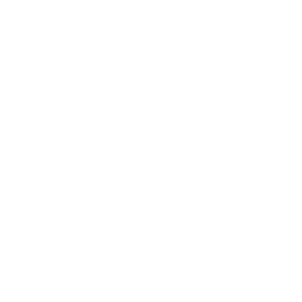

In [17]:
save_path = os.getcwd()
write_all_output(curved_linkage, io.SUBDIVISION_RESOLUTION, io.MODEL_NAME + '_manual', io.RIBBON_NAME + '_manual', False, 100, min(io.RIBBON_CS), target_width = 5, flip_angles = False, width = max(io.RIBBON_CS))
os.chdir(save_path)

Coefficient of Friction Percentiles 50, 75, 90:  0.8435700096046261 2.4215306412529367 4.786455488946784


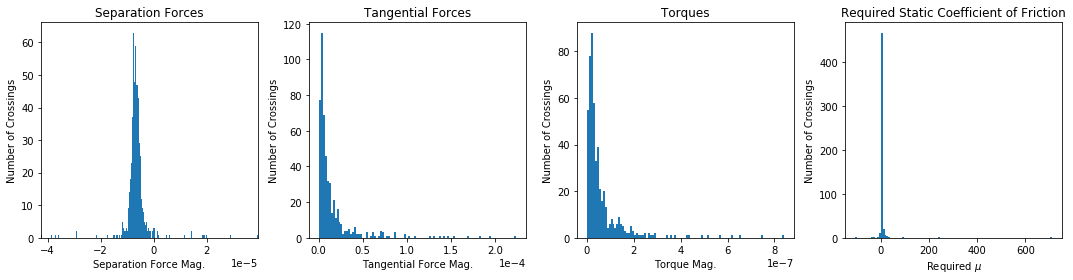

In [55]:
structure_view = get_structure_analysis_view(curved_linkage)
structure_view.show()

In [58]:
def get_opposite_joint_type(curr_type):
    if curr_type == curved_linkage.joint(0).Type.A_OVER_B:
        return curved_linkage.joint(0).Type.B_OVER_A
    return curved_linkage.joint(0).Type.A_OVER_B
import structural_analysis
cfm = structural_analysis.weavingCrossingForceMagnitudes(curved_linkage, True)
for i in np.argsort(cfm[:, 0] > 0)[-1 * np.sum(cfm[:, 0] > 0):]:
    curved_linkage.joint(i).type = get_opposite_joint_type(curved_linkage.joint(i).type)

In [ ]:
optimizer.scaleJointWeights(0.1, 1000, [396, 412, 497])
# contact_optimization(optimizer, curved_linkage_view, -1, contact_weight = 1e4)
optimizer, contact_opt_iterateData = contact_optimization(optimizer, curved_linkage, curved_linkage_view, minRestLen=-1, contact_weight = 5e6, normalWeight = 10, torqueWeight = 0, maxIter=2000, normalActivationThreshold=-1e-5)

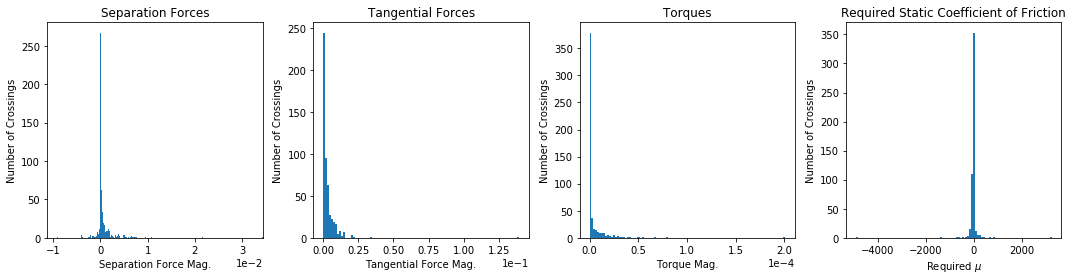

In [67]:
second_structure_view = get_structure_analysis_view(curved_linkage)
second_structure_view.show()

In [52]:
import pickle
import gzip
pickle.dump(curved_linkage, gzip.open('{}_contact_opt_by_flipping_2020_1209.pkl.gz'.format(io.MODEL_NAME), 'w'))